In [4]:
%load_ext autoreload
%autoreload 2




In [5]:

from proj.cxs_are_revealed.paper.babylm.exp3_analysis import MagpieWithSentence
from proj.cxs_are_revealed.paper.data_config import BabyLMExp3Magpie
from paper.exp3_magpie.magpie_processing_helpers import get_all_magpie_results_unclean
from paper.exp3_magpie.magpie_processing_helpers import check_data2
from paper.exp3_magpie.corpus_magpie import MLMResultForSentenceExp6, get_all_magpie_json, set_allow_deprecated
from typing import Dict
from proj.cxs_are_revealed.paper.babylm.exp3_analysis import get_word_encoding_for_offset
from typing import List
from collections import Counter
from pprint import pp
from lib.common.mlm_singleton import get_singleton_scorer
from dataclasses import dataclass

from affinity.tokenization import WordEncoding
_ =  get_singleton_scorer()



In [6]:
from dataclasses import is_dataclass
from typing import Any
def recursive_asdict(obj: Any) -> Any:
    if isinstance(obj, tuple) or is_dataclass(obj):
        if hasattr(obj, 'to_dict'):
            return {k: recursive_asdict(v) for k, v in obj.to_dict().items()}
        elif hasattr(obj, '_asdict'):
            return {k: recursive_asdict(v) for k, v in obj._asdict().items()}
    elif isinstance(obj, list):
        return [recursive_asdict(v) for v in obj]
    elif isinstance(obj, dict):
        return {k: recursive_asdict(v) for k, v in obj.items()}
    else:
        return obj




In [7]:


@dataclass
class IdiomExample:
    sent: str
    idiom: str
    label: str
    word_list: List[WordEncoding]
    score_list: List[float]

    def to_dict(self):
        return {
            'sent': self.sent,
            'idiom': self.idiom,
            'label': self.label,
            'score_avg': self.score(),
            'word_list': [w.word_chars for w in self.word_list],
            'score_list': self.score_list,
        }
    def score(self):
        if len(self.score_list) <= 0:
            print(f"score list too short")
            pp(self.word_list)
            pp(recursive_asdict(self))
            return 0
        return statistics.mean(self.score_list)

@dataclass
class IdiomCluster:
    """
    Represents a collection of examples for a given idiom
    """
    idiom: str
    idiom_examples_fig: List[IdiomExample]
    idiom_examples_lit: List[IdiomExample]
    fig_score_avg: float | None
    lit_score_avg: float | None
    fig_count: int
    lit_count: int

    def to_dict(self):
        return {
            'idiom': self.idiom,
            'fig_avg': self.fig_score_avg,
            'lit_avg': self.lit_score_avg,
            'fig_exs': sorted(self.idiom_examples_fig, key=lambda x: x.score()),
            'lit_exs': sorted(self.idiom_examples_lit, key=lambda x: x.score()),
        }





In [8]:



# copied from babyLM exp3_analysis.py
def get_word_level_scores_with_filtering(
        magpie_list: List[MagpieWithSentence],
        result_map: Dict[int, MLMResultForSentenceExp6],
        min_chars_per_word = None,
        min_sent_length = None
):
    print(len(magpie_list))
    log_counter = Counter()

    all_id_examples: List[IdiomExample] = []

    for mag_with_sent in magpie_list:
        mag_entry = mag_with_sent.magpie_entry

        sent = mag_with_sent.sentence
        if sent.word_encodings is None:
            # this happens very rarely
            log_counter["err_encoding"] += len(mag_entry.offsets)
            continue

        # these were originally implemneted in magpie_processing_helpers
        result = result_map.get(mag_entry.id)
        if not result or result.did_error:
            log_counter['error'] += len(mag_entry.offsets)
            continue
        if mag_entry.confidence < 0.99:
            log_counter['filtered_confidence'] += len(mag_entry.offsets)
            continue
        if min_sent_length and len(mag_entry.sent.split(" ")) < min_sent_length:
            log_counter['filtered_short_sent'] += len(mag_entry.offsets)
            continue

        assert result.sentence == mag_entry.sent, f"{mag_entry.id}"
        idiom_word_encodings = [get_word_encoding_for_offset(sent, x) for x in mag_entry.offsets]

        word_list: List[WordEncoding] = []
        score_list: List[float] = []
        for idx, iwe in enumerate(idiom_word_encodings):
            if iwe is None:
                log_counter["err_no_match_offset"] += 1
                continue

            if len(iwe.token_ids) != 1:
                log_counter['err_multitok'] += 1
                continue

            if min_chars_per_word and len(iwe.word_chars) < min_chars_per_word:
                log_counter['filtered_word_too_short'] += 1
                continue

            try:
                # get surprisal scores, (not HHI scores?)
                # todo: change based on which data we're reading in
                scores = result.scores[1]
                # scores = result.scores[2]
                score = scores[iwe.word_idx_in_sent]
            except:
                log_counter["err_unknown"] += 1
                continue

            word_list.append(iwe)
            # todo: change based on data we use
            # score_list.append(math.exp(-score))
            score_list.append(score)
            if mag_entry.label not in ['i', 'l']:
                raise Exception("invalid label")

        all_id_examples.append(
            IdiomExample(
                mag_entry.sent,
                mag_entry.idiom,
                mag_entry.label,
                word_list,
                score_list
            )
        )

    pp(log_counter)
    return all_id_examples



In [9]:
from proj.cxs_are_revealed.paper.babylm.exp3_analysis import get_magpie_pretty


# adapted from babyLM exp3_analysis.py
def get_magpie_data():
    # make sure we have the correct model initialized; no-op
    # _ = init_singleton_scorer(model_long)

    # use new clean babylm data
    data_dir = BabyLMExp3Magpie._exp3_magpie_cluster_out / "rob-large" / "magpie_unclean"
    # data_dir = Exp3Magpie.magpie_affinity_dir

    # read in results
    all_magpie_results = get_all_magpie_results_unclean(
        data_dir= data_dir
    )
    result_map: Dict[int, MLMResultForSentenceExp6] = {res.sentence_id : res
                                                       for res in all_magpie_results}

    # read in the output json
    all_magpie_json = get_all_magpie_json()
    all_magpie_with_sent = get_magpie_pretty(all_magpie_json)

    # verify data alignment
    fail_ct = check_data2(all_magpie_with_sent, result_map)
    print(f"fails are: {fail_ct}")
    return all_magpie_with_sent, result_map



In [10]:

set_allow_deprecated()
all_magpie_with_sent, result_map = get_magpie_data()


/Users/jsrozner/docs_local/research/projects/research_constructions/constructions_repo/proj/cxs_are_revealed/src/paper/exp3_magpie/corpus_magpie.py:19: UserWarning: Will use paper1 corpus_magpie method wrap idiom using encoding; don't use this in new code
  warnings.warn(f"Will use paper1 corpus_magpie method wrap idiom using encoding; don't use this in new code")


/Users/jsrozner/docs_local/research/projects/research_constructions/constructions_repo/proj/cxs_are_revealed/src/../data_babylm/magpie/rob-large/magpie_unclean


Token indices sequence length is longer than the specified maximum sequence length for this model (1538 > 512). Running this sequence through the model will result in indexing errors


48395 48395
check 48395; all OK
fails are: 0


In [11]:
all_idiom_examples = get_word_level_scores_with_filtering(all_magpie_with_sent, result_map)


48395
Counter({'filtered_confidence': 9996,
         'err_multitok': 3556,
         'err_no_match_offset': 2016,
         'error': 39})


In [12]:
import statistics
from collections import defaultdict


def aggregate(all_id_examples: List[IdiomExample]) -> List[IdiomCluster]:
    idiom_map: Dict[str, List[IdiomExample]] = defaultdict(list)
    for iex in all_id_examples:
        idiom_map[iex.idiom].append(iex)

    id_clusters: List[IdiomCluster] = []
    for idiom, idiom_list in idiom_map.items():
        fig_scores = []
        lit_scores = []
        fig_examples = []
        lit_examples = []
        for idiom_ex in idiom_list:
            assert len(idiom_ex.word_list) == len(idiom_ex.score_list)
            if len(idiom_ex.score_list) < 1:
                continue
            if idiom_ex.label == 'i':
                fig_scores.extend(idiom_ex.score_list)
                fig_examples.append(idiom_ex)
            else:
                lit_scores.extend(idiom_ex.score_list)
                lit_examples.append(idiom_ex)
        id_clusters.append(IdiomCluster(
            idiom,
            fig_examples,
            lit_examples,
            statistics.mean(fig_scores) if len(fig_scores) > 0 else None,
            statistics.mean(lit_scores) if len(lit_scores) > 0 else None,
            len(fig_scores),
            len(lit_scores)
        ))
    return id_clusters

idiom_clusters = aggregate(all_idiom_examples)


In [13]:

recursive_asdict(idiom_clusters[0])

{'idiom': 'off the beaten track',
 'fig_avg': 0.8296277377982888,
 'lit_avg': None,
 'fig_exs': [{'sent': 'Bob and Beryl live just off the beaten tracks',
   'idiom': 'off the beaten track',
   'label': 'i',
   'score_avg': 0.391630959076186,
   'word_list': ['off', 'beaten', 'tracks'],
   'score_list': [0.9944624304771423,
    0.1794762760400772,
    0.00095417071133852]},
  {'sent': 'But among the oldies who have given the project their support are Malcolm McLaren and Elvis Costello , which suggests that the ENO is looking for something a little off the beaten operatic track , not to say strange and unusual .',
   'idiom': 'off the beaten track',
   'label': 'i',
   'score_avg': 0.5038426170746485,
   'word_list': ['off', 'beaten', 'track'],
   'score_list': [0.9956125020980835,
    0.15392692387104034,
    0.3619884252548218]},
  {'sent': 'When an old path runs across a valley bottom , you might also improve your chances of good finds by working off the beaten track .',
   'idiom': 

In [14]:
def find_cluster(clusters: List[IdiomCluster], idiom: str):
    for c in clusters:
        if c.idiom.lower() == idiom.lower():
            return c
    return None



In [73]:
c = find_cluster(idiom_clusters, "nuts and bolts")
print(len(c.idiom_examples_lit))
print(len(c.idiom_examples_fig))
# pp(c)
recursive_asdict(c)

17
30


{'idiom': 'nuts and bolts',
 'fig_avg': 0.9035936248444668,
 'lit_avg': 0.8375717367903859,
 'fig_exs': [{'sent': 'At the nuts and bolts level , significant progress was made towards achieving a full internal market by January 1 , 1993 , with member countries heeding the warning of the Europen Commission president , Mr Jacques Delors , that further delays in implementing the raft of legislation could cause real problems .',
   'idiom': 'nuts and bolts',
   'label': 'i',
   'score_avg': 0.31821987003885965,
   'word_list': ['nuts', 'and', 'bolts'],
   'score_list': [1.2561845323943999e-06,
    0.9546582698822021,
    8.404984441767738e-08]},
  {'sent': 'This page is concerned with the ‘ nuts and bolts’ of your Enterprise holiday .',
   'idiom': 'nuts and bolts',
   'label': 'i',
   'score_avg': 0.43935730517841876,
   'word_list': ['nuts', 'and'],
   'score_list': [0.007531691808253527, 0.871182918548584]},
  {'sent': 'Their bosses , sitting on the senior loan committee , are pragmatic 

In [16]:
# filter clusters
filtered_clusters = [ c for c in idiom_clusters if len(c.idiom_examples_fig) > 4 and len(c.idiom_examples_lit) > 4]
print(len(filtered_clusters))

def calc_med_score_fig(c: IdiomCluster):
    all_vals = []
    for id in c.idiom_examples_fig:
        all_vals.extend(id.score_list)
    return statistics.median(all_vals)

filtered_sorted = sorted(filtered_clusters, key=lambda x: x.fig_score_avg, reverse=True)
# filtered_sorted = sorted(filtered_clusters, key=lambda x: calc_med_score_fig(x), reverse=True)
recursive_asdict(filtered_sorted[0])


203


{'idiom': 'in a rut',
 'fig_avg': 0.9907324680915246,
 'lit_avg': 0.5886687323451042,
 'fig_exs': [{'sent': 'It was on points like these that the debate always stuck in a rut .',
   'idiom': 'in a rut',
   'label': 'i',
   'score_avg': 0.9698476195335388,
   'word_list': ['in'],
   'score_list': [0.9698476195335388]},
  {'sent': 'After just one feature , Electric Dreams , British video whiz - kid Steve Barron was in a rut .',
   'idiom': 'in a rut',
   'label': 'i',
   'score_avg': 0.9818312525749207,
   'word_list': ['in'],
   'score_list': [0.9818312525749207]},
  {'sent': 'Any failure to develop and promote a range of options — or the production of services ill - suited to real needs — deepens the likelihood of casework becoming trapped in a rut of ‘ patch and mend’ activities .',
   'idiom': 'in a rut',
   'label': 'i',
   'score_avg': 0.9835150241851807,
   'word_list': ['in'],
   'score_list': [0.9835150241851807]},
  {'sent': "I know , but that , at St. Hughes you 're stuck in a

/Users/jsrozner/docs_local/research/projects/research_constructions/constructions_repo/rozlib-python/rozlib/libs/plotting/utils_latex_matplot.py:46: UserWarning: /Library/TeX/textbin will be added to path
  # font_size = 12
/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_84856/1494712157.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=50, ha='right')
/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_84856/1494712157.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=50, ha='right')


3


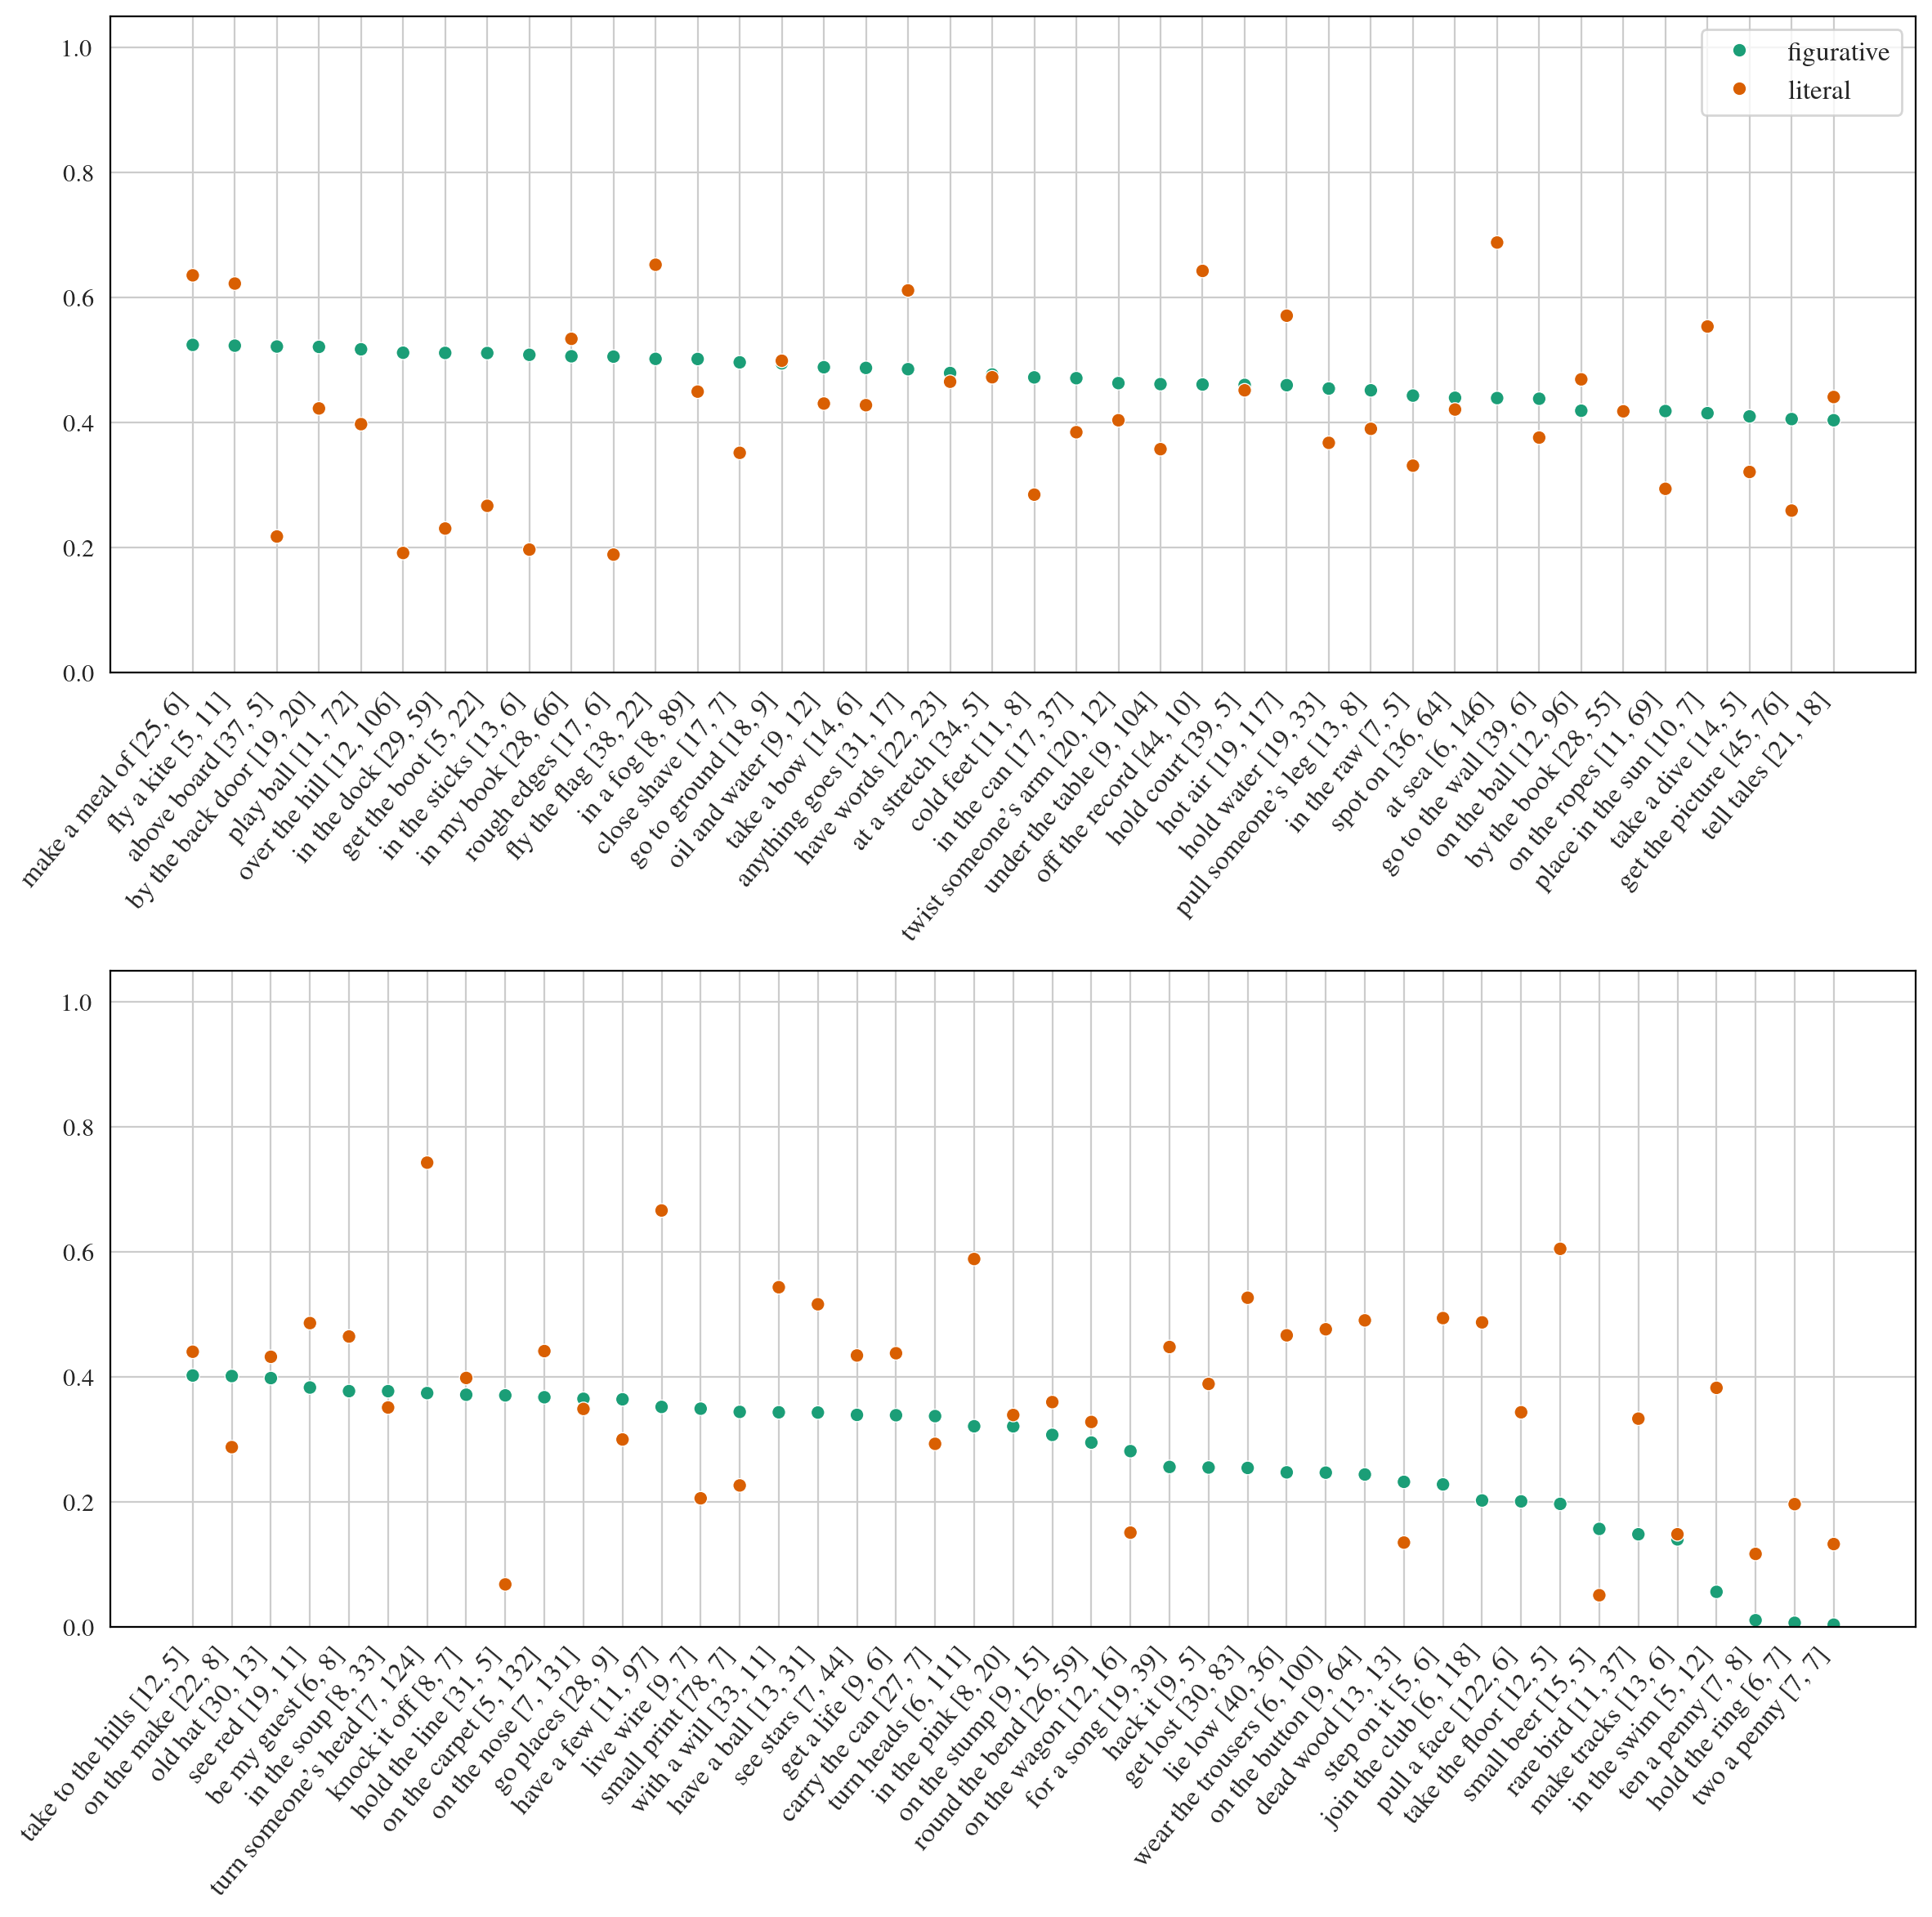

In [68]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rozlib.libs.plotting.utils_latex_matplot import config_matplot_for_latex, FigSaver

# match umap plot
cmap = plt.cm.Dark2.colors[:2]


def plot_idiom_avg_scores(
        clusters: list[IdiomCluster],
        add_x_labels=True,
        ax= None,
        legend = True
):
    # Build a dataframe with just the averages
    data = []
    labels = []
    for cluster in clusters:
        assert len(cluster.idiom_examples_fig) > 4
        assert len(cluster.idiom_examples_lit) > 4
        data.append({'idiom': cluster.idiom, 'type': 'figurative', 'score': cluster.fig_score_avg})
        data.append({'idiom': cluster.idiom, 'type': 'literal', 'score': cluster.lit_score_avg})
        labels.append(f"{cluster.idiom} [{len(cluster.idiom_examples_fig)}, {len(cluster.idiom_examples_lit)}]")
        # labels.append(f"[{len(cluster.idiom_examples_fig)}, {len(cluster.idiom_examples_lit)}] - {cluster.idiom}")
        # data.append({'idiom': cluster.idiom, 'type': 'diff', 'score': cluster.fig_score_avg - cluster.lit_score_avg})
    df = pd.DataFrame(data)

    # Plot
    if ax is None:
        fix, ax = plt.subplots(figsize=(12, 4))

    # plt.figure(figsize=(12, 4))
    # plt.title("Average Figurative vs Literal Score per Idiom")

    ax.grid(True)
    sns.scatterplot(
        data=df,
        x='idiom',
        y='score',
        hue='type',
        # palette='Set2',
        palette=cmap,
        ax=ax
    )
    if add_x_labels:
        # ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
        ax.set_xticklabels(labels, rotation=50, ha='right')
        # ax.set_xticks(rotation=35, ha='right')
    else:
        ax.set_xticks([])
    ax.set_ylim(0, 1.05)
    ax.legend_.set_title(None)

    if not legend:
        ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    # plt.grid()
    # if add_x_labels:
    #     # ax.tick_params(axis='x', rotation=35)
    #     plt.xticks(rotation=35, ha='right')
    # else:
    #     plt.xticks([])
    # plt.ylim(0, 1.05)
    # ax.tight_layout()
    # plt.show()

# plot_idiom_avg_scores(filtered_sorted, add_x_labels=False)
        # plot_idiom_avg_scores(filtered_sorted[:10] + filtered_sorted[100:110]+filtered_sorted[150:160]+filtered_sorted[-10:])
# plot_idiom_avg_scores(filtered_sorted[-50:])
# plot_idiom_avg_scores(filtered_sorted[100:150])
# plot_idiom_avg_scores(filtered_sorted[:50], ax=None)

def plot_all1():
    fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharey=True)
    axes = axes.flatten()
    print(len(axes))
    # for ax in axes:
    plot_idiom_avg_scores(filtered_sorted[:40], ax=axes[0])
    plot_idiom_avg_scores(filtered_sorted[40:80], ax=axes[1], legend=False)
    plot_idiom_avg_scores(filtered_sorted[80:120], ax=axes[2], legend=False)
    # plot_idiom_avg_scores(filtered_sorted[150:203], ax=axes[3], legend=False)
    plt.tight_layout()  # fixes overlap with the xticks
    return fig

def plot_all2():
    fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharey=True)
    axes = axes.flatten()
    print(len(axes))
    # for ax in axes:
    plot_idiom_avg_scores(filtered_sorted[120:160], ax=axes[0])
    plot_idiom_avg_scores(filtered_sorted[160:203], ax=axes[1], legend=False)
    axes[2].set_visible(False)
    # plot_idiom_avg_scores(filtered_sorted[80:120], ax=axes[2], legend=False)
    # plot_idiom_avg_scores(filtered_sorted[150:203], ax=axes[3], legend=False)
    plt.tight_layout()  # fixes overlap with the xticks
    return fig

figs_dir = Path("../../../supplemental/figs")
fs=FigSaver(figs_dir)
os.environ["TOKENIZERS_PARALLELISM"] = "true"
config_matplot_for_latex(12, dpi=200)

# fig = plot_all1()
# fs.save(fig, "idioms-fig-vs-lit")
fig = plot_all2()
fs.save(fig, "idioms-fig-vs-lit2")




In [59]:

contents = os.listdir("../../../../..")
print(contents)


['proj', 'rsync_data.txt', 'mag_out.zip', '.DS_Store', 'pyrightconfig.json', 'requirements.txt', 'magout_2.zip', 'output', 'env.yml', '.tach', '.gitignore', '.env', 'tach.toml', 'rsync.txt', 'rozlib-python', '.git', '.idea']


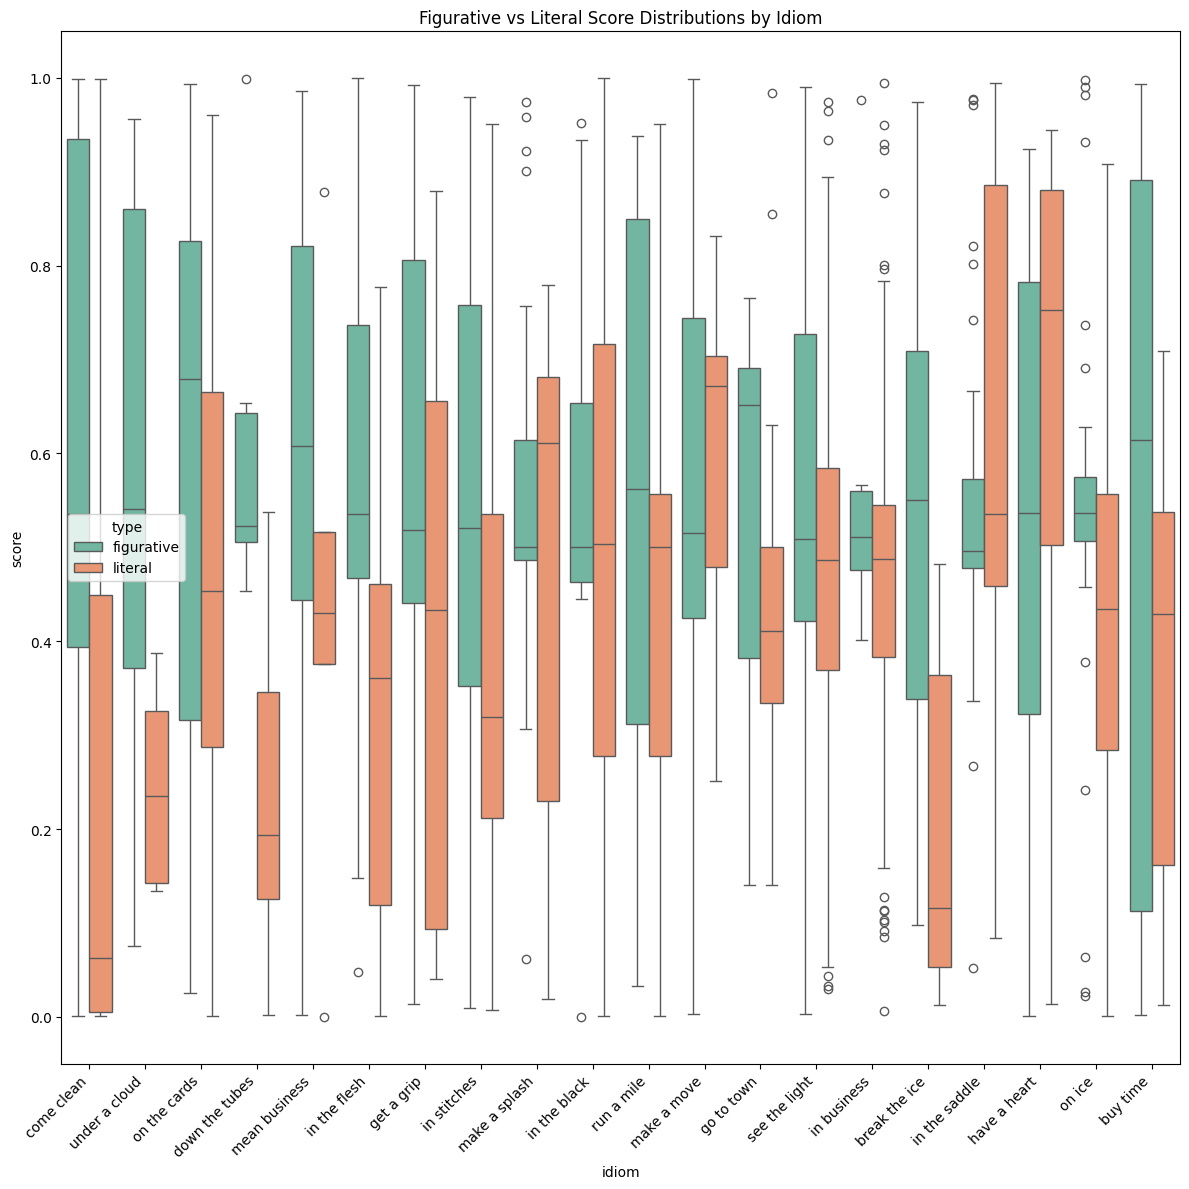

In [266]:

def plot_idiom_cluster_violins(clusters: list[IdiomCluster]):
    # Flatten into a DataFrame
    data = []
    for cluster in clusters:
        for ex in cluster.idiom_examples_fig:
            data.append({
                'idiom': cluster.idiom,
                'score': ex.score(),
                'type': 'figurative',
            })
        for ex in cluster.idiom_examples_lit:
            data.append({
                'idiom': cluster.idiom,
                'score': ex.score(),
                'type': 'literal',
            })
    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(12, 12))
    sns.boxplot(
        data=df,
        x='idiom',
        y='score',
        hue='type',
        palette='Set2',
        # split=True,
        # inner='quartile',
        # scale="width",
        # cut=0
    )
    plt.title("Figurative vs Literal Score Distributions by Idiom")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_idiom_cluster_violins(filtered_sorted[100:120])

In [69]:
from typing import NamedTuple

# this is aggregate
class IdiomInfo(NamedTuple):
    idiom: str
    idiom_score: float
    literal_score: float
    score_cts: Tuple[int, int]

def get_all_idiom_info() -> List[IdiomInfo]:
    all_ret: List[IdiomInfo] = []
    for d in zip(*get_all_idiom_averages(wulff_acc)):
        all_ret.append(IdiomInfo(*d))
    return all_ret

all_idiom_info = get_all_idiom_info()

def get_from_idiom_info(idiom_info: List[IdiomInfo], search_idiom: str):
    search_idiom = search_idiom.lower()
    for i in range(0, len(idiom_info)):
        if idiom_info[i].idiom.lower() == search_idiom:
            return idiom_info[i]
    return None

get_from_idiom_info(all_idiom_info, "nuts and bolts")
get_from_idiom_info(all_idiom_info, "drop the ball")
get_from_idiom_info(all_idiom_info, "turn someone's head")


NameError: name 'Tuple' is not defined